In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

#Libraries for formattting and handling text 
import string 
import re

#Library for nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS


#Library for Splitting Dataset
from sklearn.model_selection import train_test_split


#Libraries for NN
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import TweetTokenizer

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout

from tensorflow.keras.utils import plot_model

#Library for evaluation
from sklearn import metrics
from functools import reduce
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict

import pandas as pd

### Step 1: Import training and testing dataset and check out data properties

In [15]:
train_data = pd.read_csv('D:/WorkSample/Natural-Language-Processing-with-Disaster-Tweets--main/train.csv')
test_data  = pd.read_csv('D:/WorkSample/Natural-Language-Processing-with-Disaster-Tweets--main/test.csv')

In [16]:
train_data.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [17]:
print('There are {} rows and {} columns in train'.format(train_data.shape[0],train_data.shape[1]))
print('There are {} rows and {} columns in train'.format(test_data.shape[0],test_data.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in train


In [18]:
train_data['text'][1]

'Forest fire near La Ronge Sask. Canada'

C:\Users\yanli\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'samples')

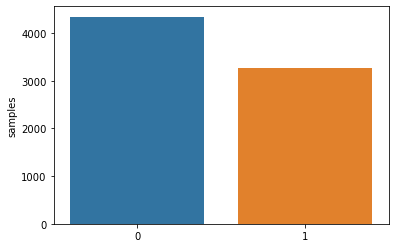

In [19]:
#Data distribution check. Let's see if this dataset is extremely imbalannced or not.
x=train_data.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

The picture following can show us distributions of the number of characters for each class

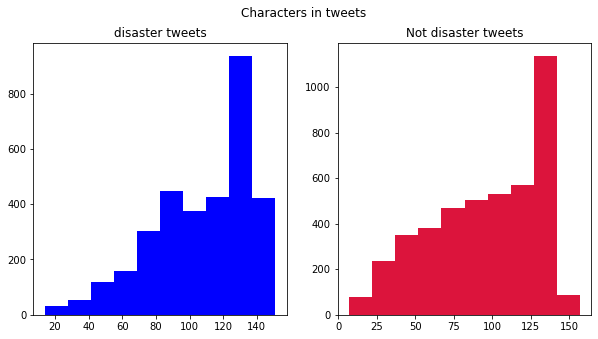

In [20]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train_data[train_data['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=train_data[train_data['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='CRIMSON')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

The picture following can show us distributions of the number of words for each class

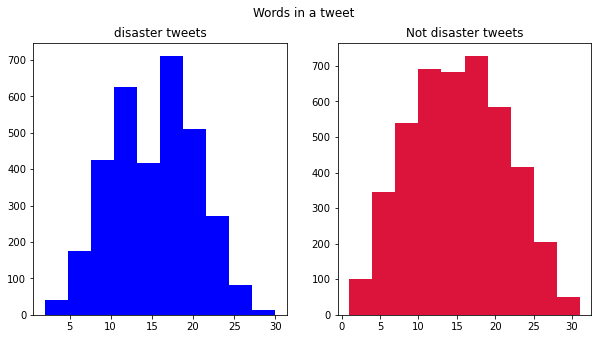

In [21]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train_data[train_data['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=train_data[train_data['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='CRIMSON')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

<BarContainer object of 30 artists>

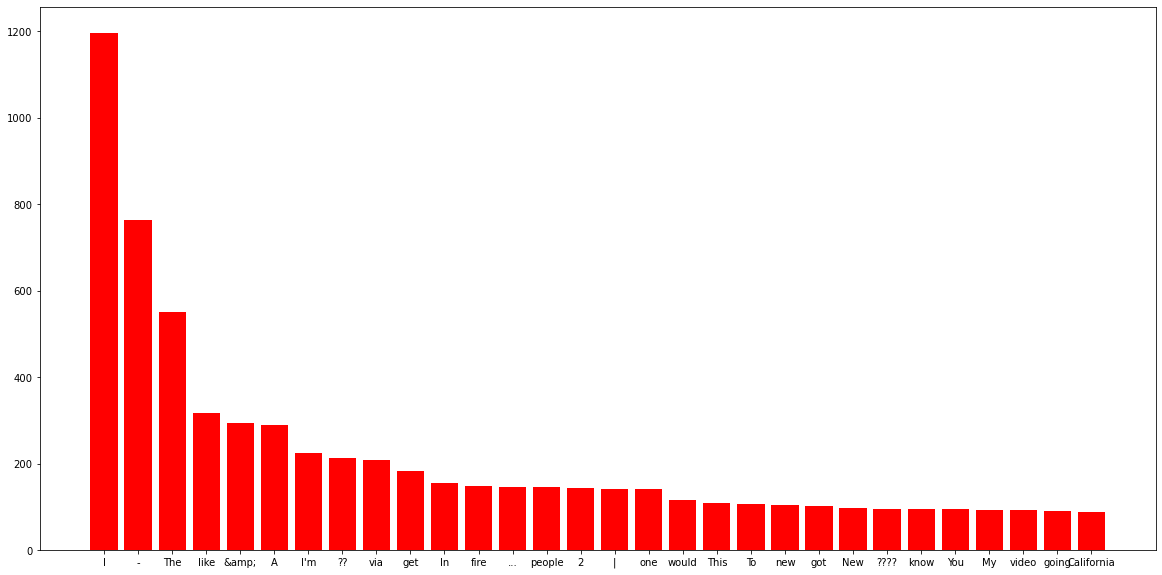

In [22]:
#Code following will generate a list that contains all the words in the 'text' column of training data
corpus=[]
    
for x in train_data['text'].str.split():
    for i in x:
        corpus.append(i)

#Code bellow will create a dictionary that contains all the words that are NOT stopwords       
dic=defaultdict(int)
for word in corpus:
    if word not in stop:
        dic[word]+=1

#Picture below will show top 30 frequently used words
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:30] 
x,y=zip(*top)
plt.rcParams["figure.figsize"] = (20,10)
plt.bar(x,y , color ='red')

<BarContainer object of 30 artists>

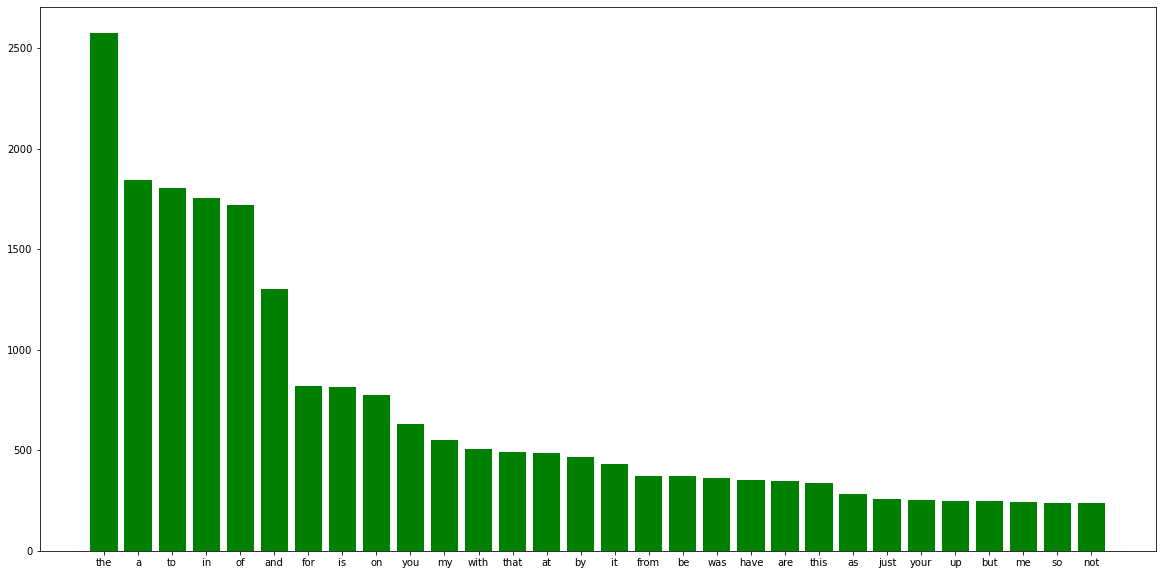

In [23]:
#The code logic below is queit same with cell above. However, the bar chart below 
#shows the top 30 frequently used stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:30] 
x,y=zip(*top)
plt.rcParams["figure.figsize"] = (20,10)
#There is also this workaround in case you want to change the size without using the figure environment.
#So in case you are using plt.plot() for example, you can set a tuple with width and height.
plt.bar(x,y , color ='green')

<BarContainer object of 23 artists>

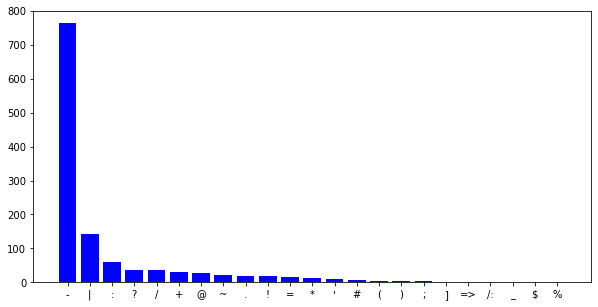

In [24]:
#We can use the same logic to get same chart with punctuations. 
plt.figure(figsize=(10,5))
import string
dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
top=sorted(dic.items(), key=lambda x:x[1],reverse=True) 
x,y=zip(*top)
plt.bar(x,y ,color = 'blue')

### Step 2 : Data sanitizing following  NLP process

The following four functions are designed to sanitize the text filed. 

In [25]:
#Function that remove special characters
def RemoveUnnecessaryChar(sentence):
    for sentence1 in sentence:
        sentence1 = str(sentence1)
        sentence1 = sentence1.lower()
        formatted_sent = re.sub(r'https?:\/\/.*[\r\n]*','',sentence1) #  Remove hyperlinks
        formatted_sent = formatted_sent.replace('{html}',"")
        formatted_sent = re.sub(r'#','',formatted_sent) # Removed Hashtags
        formatted_sent = re.sub(r'[0-9]','',formatted_sent) # Removes Numbers
        formatted_sent = re.sub(r'@[A-Za-z]*','',formatted_sent) # Removed @ Tags
        formatted_sent = re.sub(r"["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", "", formatted_sent)
        
        sent.append(formatted_sent)

In [26]:
#Function that tokenizes each text
def TokenizeSentence(sentence):
    tokenizer = TweetTokenizer(preserve_case = False,strip_handles = True,reduce_len=True)
    for sentence in sent:
        tokenized_sentence = tokenizer.tokenize(sentence)
        tokenized_sent.append(tokenized_sentence)

In [27]:
#Function that removes stop words
def stopwordsSentence(sent):
    for sentence in sent:
        formatted_words=[]
        for word in sentence:
            if word not in stopwords_eng and word not in string.punctuation and len(word)>2:
                formatted_words.append(word)
        formatted_sent.append(formatted_words)

Why we choose lemmatizing rather than stemming? Lemmatizing is more powerful and smarter than stemming since lemmatizing use morphological analysis to look up proper form of a word in the dictionary. Stemming simply cut the suffix from the word. 

In [28]:
#Function that lemmatize the text
def lemmatizeSentence(sent):
    lemma = WordNetLemmatizer()
    for sentence in sent:
            lemma_words = []
            for word in sentence:
                lemma_word = lemma.lemmatize(word)
                lemma_words.append(lemma_word)
            lemma_sent.append(lemma_words)

Let's drop columns that are not useful to the machine learning model and add the sanitized text as a new column.

In [31]:
sent = []
RemoveUnnecessaryChar(train_data['text'])
tokenized_sent = []
TokenizeSentence(sent)
stopwords_eng = stopwords.words('english')
formatted_sent = []
stopwordsSentence(tokenized_sent)
lemma_sent = []
lemmatizeSentence(formatted_sent)
train_data['FinalText'] = lemma_sent
train_data = train_data.drop(['id','keyword','location','text'],axis = 1)
train_data.head()

,target,FinalText
0,1,"[deed, reason, earthquake, may, allah, forgive]"
1,1,"[forest, fire, near, ronge, sask, canada]"
2,1,"[resident, asked, shelter, place, notified, of..."
3,1,"[people, receive, wildfire, evacuation, order,..."
4,1,"[got, sent, photo, ruby, alaska, smoke, wildfi..."


The following cells are about training and fitting the LSTM model. 

In [36]:
max_features=3000

#Tokenizer is supported by Tensorflow, and it is used to encode text tokens to numeric values
#The reason why we use numeric values rather than text tokens is that for LSTM embedding layers, numeric
#values are required. Machine cannot read text.
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(train_data['FinalText'].values)
#Fit_on_texts() Updates internal vocabulary based on a list of texts. 
#It will create a dictionary with word mapping with an index (unique numerical value).

X = tokenizer.texts_to_sequences(train_data['FinalText'].values)
#texts_to_sequences() Transforms each text in texts to a sequence of numerical value. 
#It will give assign the index of each to the word. So the output will be series of numerical values.

X = pad_sequences(X)
#Pad_sequence is used to keep all sentence in the text field in the same dimension. Since each sentence has
#different length. Pad_sequences will add bunch of zeros to the input. 
X[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,  421,  208,   61, 1305])

In [33]:
y = train_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =41)

In [37]:
embed_dim = 32
lstm_out = 32
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
#The code above is to set up the embedding layer for our LSTM model, which is setting up the input_dim, output_dim and 
#input_length to 32. 

model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.4))
#Dropout is added to avoid overfitting. 

model.add(Dense(1,activation='sigmoid'))
#Activation Function of Dense layer, i.e, is output layer is taken 
#as Sigmoid function is taken as it is good at binary classification and our target column have value either 0 or 1.

adam = optimizers.Adam(learning_rate=0.002)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
#Adam is used as optimizer which is replacement optimization algorithm for 
#stochastic gradient descent for training deep learning models.
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 32)            96000     
                                                                 
 dropout (Dropout)           (None, 17, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 104,353
Trainable params: 104,353
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
model.fit(X_train, y_train, epochs = 10, batch_size=32, validation_data=(X_test, y_test))
y_pred = model.predict(X_test).round()

Epoch 1/10
191/191 [==============================] - 4s 11ms/step - loss: 0.5400 - accuracy: 0.7200 - val_loss: 0.4221 - val_accuracy: 0.8181
Epoch 2/10
191/191 [==============================] - 2s 10ms/step - loss: 0.3795 - accuracy: 0.8365 - val_loss: 0.4323 - val_accuracy: 0.8083
Epoch 3/10
191/191 [==============================] - 2s 10ms/step - loss: 0.3262 - accuracy: 0.8644 - val_loss: 0.4591 - val_accuracy: 0.7991
Epoch 4/10
191/191 [==============================] - 2s 10ms/step - loss: 0.2923 - accuracy: 0.8788 - val_loss: 0.5014 - val_accuracy: 0.7840
Epoch 5/10
191/191 [==============================] - 2s 10ms/step - loss: 0.2715 - accuracy: 0.8865 - val_loss: 0.5532 - val_accuracy: 0.7787
Epoch 6/10
191/191 [==============================] - 2s 10ms/step - loss: 0.2459 - accuracy: 0.9005 - val_loss: 0.5999 - val_accuracy: 0.7728
Epoch 7/10
191/191 [==============================] - 2s 10ms/step - loss: 0.2227 - accuracy: 0.9071 - val_loss: 0.6760 - val_accuracy: 0.7735

We can see that precision and recall of our model are both over 70%, which is good enough for a experimental project

In [39]:
print('Accuracy  is  : ', (metrics.accuracy_score(y_test, y_pred)))
print('Recall  is    : ', (metrics.recall_score(y_test, y_pred)))
print('Precision  is : ', (metrics.precision_score(y_test, y_pred)))

Accuracy  is  :  0.7616546290216678
Recall  is    :  0.7301829268292683
Precision  is :  0.7203007518796992


In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79       867
           1       0.72      0.73      0.73       656

    accuracy                           0.76      1523
   macro avg       0.76      0.76      0.76      1523
weighted avg       0.76      0.76      0.76      1523



### Reference:
#### 1. https://www.kaggle.com/code/naim99/your-first-nlp-competition-submission/notebook#Fitting-the-Test-data-for-submission
#### 2.  https://www.kaggle.com/code/sandhyakrishnan02/nlp-with-disaster-tweets-using-lstm#10.-Model-creation-Using-LSTM